# Скачиваем данные

In [ ]:
!wget https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/TRAIN_ASP.txt
!wget https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/TRAIN_CATS.txt
!wget https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/dev_cats.txt
!wget https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/dev_pred_aspects_sent.txt

--2022-12-29 01:33:43--  https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/TRAIN_ASP.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228391 (223K) [text/plain]
Saving to: ‘TRAIN_ASP.txt’

TRAIN_ASP.txt       100%[===================>] 223.04K  --.-KB/s    in 0.006s  

2022-12-29 01:33:43 (37.1 MB/s) - ‘TRAIN_ASP.txt’ saved [228391/228391]

--2022-12-29 01:33:43--  https://raw.githubusercontent.com/knapweedss/aspect-based-SA/main/files_for_cats/TRAIN_CATS.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

# Подсчитываем частотность 

In [ ]:
import pandas as pd
def compute_frequency(aspects, sentiments):
    """
    Считаем количество упоминаний
    для тональностей по категориям
    """
    ids = aspects['text_id'].unique() # получаем массив
    df_frames = [] # датафреймы, которые потом конкатенируем
    for j in ids:
        both = {'Whole':0, 'Service':0, 'Food':0, 'Interior':0, 'Price':0}
        positive = {'Whole':0, 'Service':0, 'Food':0, 'Interior':0, 'Price':0}
        negative = {'Whole':0, 'Service':0, 'Food':0, 'Interior':0, 'Price':0}
        neutral = {'Whole':0, 'Service':0, 'Food':0, 'Interior':0, 'Price':0}
        frequency = {'Whole':0, 'Service':0, 'Food':0, 'Interior':0, 'Price':0}

        asp = aspects.loc[aspects['text_id']==j]
        asp = asp.reset_index()
        for i in range(len(asp)):
            if asp['sentiment'][i] == 'neutral':
                neutral[asp['category'][i]] +=1
            if asp['sentiment'][i] == 'positive':
                positive[asp['category'][i]] +=1
            if asp['sentiment'][i] == 'negative':
                negative[asp['category'][i]] +=1
            if asp['sentiment'][i] == 'both':
                both[asp['category'][i]] +=1
        partition = sentiments.loc[sentiments['text_id']==j]
        partition = partition.reset_index()
        partition['positive'] = 0
        partition['negative'] = 0
        partition['both'] = 0
        partition['neutral'] = 0
        for i in range(5):
            partition.at[i,'positive'] = positive[partition['category'][i]]
            partition.at[i, 'negative'] = negative[partition['category'][i]]
            partition.at[i, 'both'] = both[partition['category'][i]]
            partition.at[i, 'neutral'] = neutral[partition['category'][i]]
        df_frames.append(partition)
    return pd.concat(df_frames)

In [ ]:
train_asp = pd.read_csv(
    'TRAIN_ASP.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_sent = pd.read_csv(
    'TRAIN_CATS.txt',
    delimiter='\t',
    names=['text_id', 'category', 'sentiment'])
train = compute_frequency(train_asp, train_sent)

In [ ]:
test = compute_frequency(pd.read_csv('dev_pred_aspects_sent.txt',  delimiter='\t', names=['text_id', 'category', 'text', 'start', 'end', 'sentiment']), 
                            pd.read_csv('dev_cats.txt', delimiter='\t', names=['text_id', 'category', 'sentiment']))

# Тестим классификаторы

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [243]:
train

,index,text_id,category,sentiment,positive,negative,both,neutral
0,0,3976,Food,positive,2,0,0,1
1,1,3976,Interior,positive,4,0,0,0
2,2,3976,Price,absence,0,0,0,0
3,3,3976,Whole,positive,2,0,0,5
4,4,3976,Service,positive,4,0,1,1
...,...,...,...,...,...,...,...,...
0,1415,16630,Food,positive,1,0,0,0
1,1416,16630,Interior,positive,1,0,0,0
2,1417,16630,Price,absence,0,0,0,0
3,1418,16630,Whole,positive,2,0,0,0


In [245]:
train_m = train[['category','sentiment', 'positive', 'negative',	'both',	'neutral']]

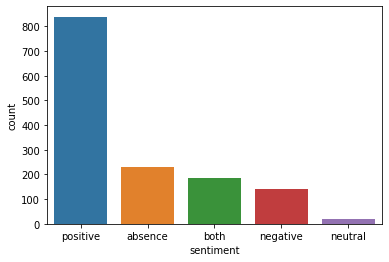

In [249]:
sns.countplot(train['sentiment'],label='count',)

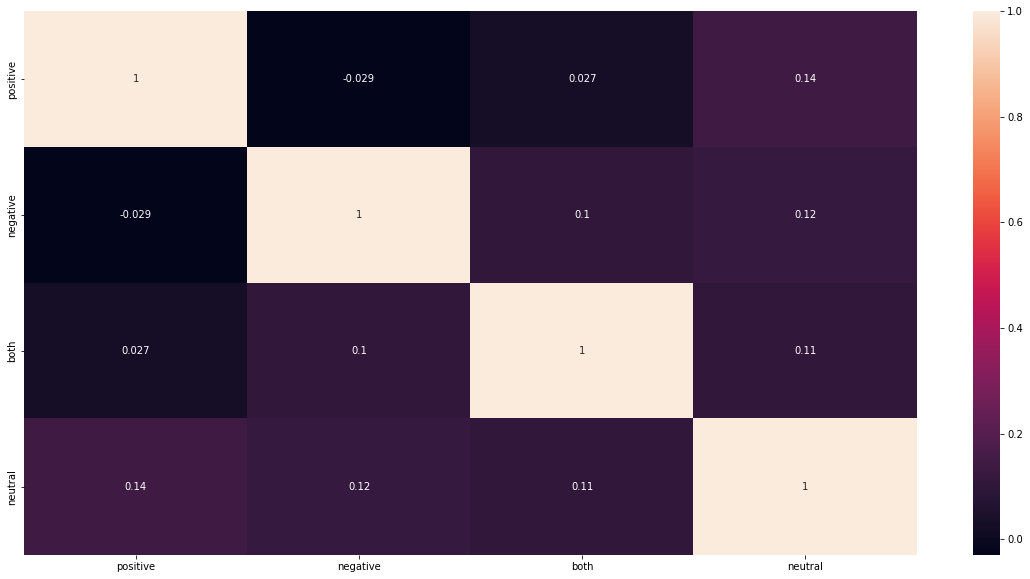

In [253]:
plt.figure(figsize=(20,10)) 
sns.heatmap(train_m.corr(), annot=True) 
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
y_train = LE.fit_transform(train['sentiment'])

In [ ]:
features_columns = list(test.keys()[4::])
features_columns

['positive', 'negative', 'both', 'neutral']

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import GridSearchCV

# Random Forest + GridSearchcv

In [ ]:
X_train = train[features_columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
params = {
    'criterion':['gini','entropy'],
    'n_estimators':[20,50,75,100],
    'max_features':['auto','sqrt','log2'],
    'class_weight':['balanced','balanced_subsample']
}

In [ ]:
rf = RandomForestClassifier()
grid = GridSearchCV(rf, params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 20}
Accuracy:0.8077715631439505


# SVM + GridSearchCV

In [ ]:
from sklearn import svm
clf = svm.SVC()
parameters_svm = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                  'gamma': ('scale', 'auto'),
                  'shrinking': (True, False),
               'class_weight': ('balanced', None),
                 'decision_function_shape': ('ovo', 'ovr')}


grid_search_SVM = GridSearchCV(clf, parameters_svm, n_jobs=-1, scoring = "f1_weighted")
grid_search_SVM = grid_search_SVM.fit(X_train, y_train)


print(grid_search_SVM.best_score_)
print(grid_search_SVM.best_params_)

0.8199798171305488
{'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}


In [ ]:
y_test = LE.transform(test['sentiment'])
y_pred = grid_search_SVM.predict(test[features_columns])

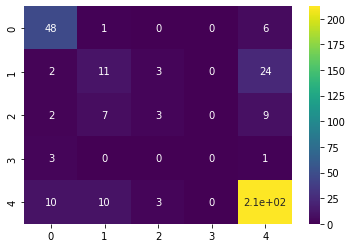

In [233]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,cmap='viridis')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85        55
           1       0.22      0.40      0.29        40
           2       0.29      0.19      0.23        21
           3       0.20      0.50      0.29         4
           4       0.85      0.73      0.79       235

    accuracy                           0.68       355
   macro avg       0.48      0.54      0.49       355
weighted avg       0.74      0.68      0.70       355



# LogisticRegression + GridSearchCV

Обычно в задачах классификации лог. рег. показывает хорошие результаты, поэтому будем использовать пайплайн и посмотрим подробнее на параметры

In [ ]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
std_slc = StandardScaler()

In [ ]:
std_slc = StandardScaler()

In [ ]:
pca = decomposition.PCA()

In [ ]:
logistic_Reg = linear_model.LogisticRegression()

In [ ]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

In [ ]:
n_components = list(range(1,X_train.shape[1]+1,1))

In [ ]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

In [ ]:
parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic_Reg', LogisticRegression())]),
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3,

In [ ]:
print(clf_GS.best_params_)
print(clf_GS.best_score_)

{'logistic_Reg__C': 0.12648552168552957, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 4}
0.8246478873239436


In [ ]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 0.12648552168552957
Best Number Of Components: 4

LogisticRegression(C=0.12648552168552957)


# KNN + GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}

grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5)

grid_search_KNN.fit(X_train, y_train)

print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.8169014084507042


**Лучшие результаты показывает логистическая регрессия**

# Обучение

In [ ]:
lg = clf_GS.best_estimator_.get_params()['logistic_Reg']

In [ ]:
lg.fit(X_train, y_train)

LogisticRegression(C=0.12648552168552957)

In [ ]:
y_pred = lg.predict(test[features_columns])
accuracy_score(y_test, y_pred)

0.7718309859154929

In [ ]:
X = pd.read_csv(
    'dev_pred_aspects_sent.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
y = pd.read_csv('dev_cats.txt', delimiter='\t', names=['text_id', 'category', 'sentiment'])

In [ ]:
res = compute_frequency(X, y)

In [ ]:
y_pred = lg.predict(res[features_columns])

In [ ]:
def norm_result(X_, y_):
    in_df = X_
    y_ = LE.inverse_transform(y_)
    X_['sentiment'] = 0
    X_['sentiment'] = y_
    X_.drop(['positive', 'negative', 'both', 'neutral', 'index'], axis=1, inplace=True)
    return X_

In [ ]:
final = norm_result(res, y_pred)

In [ ]:
final.to_csv('dev_pred_cats.txt', sep='\t', header=False, index=False)

In [ ]:
import pickle
pickle.dump(lg, open('part3.sav', 'wb'))

# Оценка

In [ ]:
gold_test_cats_path = "dev_cats.txt"
pred_test_cats_path = "dev_pred_cats.txt"

In [ ]:
with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
    gold_labels = set(gc.readlines())
    pred_labels = set(pc.readlines())
    print(
        "Overall sentiment accuracy:",
        len(gold_labels & pred_labels) / len(gold_labels)
    )

Overall sentiment accuracy: 0.7718309859154929
